<a href="https://colab.research.google.com/github/Wise-Wizard/Intrusion-Detection-BTP/blob/master/Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, ZeroPadding2D
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [55]:
df = pd.read_csv('preprocessedCIC.csv').sample(frac=1).reset_index(drop=True)[:200000]
df = df.replace([np.inf, -np.inf], np.nan).dropna()

In [56]:
df.shape

(20416, 39)

In [57]:
df["Label"].value_counts()

Label
BENIGN                      17425
DoS Hulk                     1479
DDoS                         1017
PortScan                      214
DoS GoldenEye                  76
FTP-Patator                    55
DoS slowloris                  45
DoS Slowhttptest               38
SSH-Patator                    36
Web Attack  Brute Force       18
Bot                             9
Web Attack  XSS                4
Name: count, dtype: int64

In [58]:
cl = len(df["Label"].value_counts())
cl

12

In [59]:
# Define the minority and majority classes
minority_class = ['Web Attack  Sql Injection', 'Infiltration', 'Web Attack  XSS']
majority_class = ['BENIGN', 'DoS Hulk', 'DDoS', 'PortScan', 'Web Attack  Brute Force', 'Bot', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'SSH-Patator', 'DoS GoldenEye']

# Split the dataset into minority and majority
minority = df[df['Label'].isin(minority_class)].reset_index(drop=True)
majority = df[df['Label'].isin(majority_class)].reset_index(drop=True)

In [60]:
enn = NearestNeighbors(n_neighbors=500)
enn.fit(majority.drop(columns=['Label']))
difficult_idx = enn.kneighbors(minority.drop(columns=['Label']), return_distance=False).flatten()
difficult = df.iloc[difficult_idx]
easy = df.reset_index(drop=True).drop(difficult_idx)

In [61]:
difficult["Label"].value_counts()

Label
BENIGN                      1720
DoS Hulk                     120
DDoS                         109
PortScan                      23
FTP-Patator                    8
DoS GoldenEye                  7
DoS Slowhttptest               5
Web Attack  Brute Force       4
DoS slowloris                  3
SSH-Patator                    1
Name: count, dtype: int64

In [62]:
easy["Label"].value_counts()

Label
BENIGN                      16818
DoS Hulk                     1436
DDoS                          978
PortScan                      206
DoS GoldenEye                  74
FTP-Patator                    52
DoS slowloris                  44
DoS Slowhttptest               36
SSH-Patator                    35
Web Attack  Brute Force       17
Bot                             9
Web Attack  XSS                4
Name: count, dtype: int64

In [63]:
# Use KMeans to compress majority samples in the difficult set
kmeans = KMeans(n_clusters=100)
kmeans.fit(difficult.drop(columns=['Label']))
compressed = pd.DataFrame(kmeans.cluster_centers_, columns=difficult.columns[:-1])
compressed['Label'] = 'BENIGN'

In [64]:
# Generate synthetic minority samples in the difficult set
difficult_min = difficult[difficult['Label'].isin(minority_class)]
difficult_max = difficult[difficult['Label'] == 'BENIGN']
difficult_range = difficult_max - difficult_min
difficult_samples = pd.DataFrame()

In [65]:
for i in range(10):
  r = pd.DataFrame(columns=difficult_min.columns[:-1])
  random_values = np.random.rand(difficult_min.shape[1]-1)
  r.loc[0] = random_values
  dm = difficult_min.iloc[:,:-1]
  sample = dm.add(r, fill_value=0)
  sample['Label'] = minority_class[np.random.randint(0, len(minority_class))]
  difficult_samples = pd.concat([difficult_samples, sample], ignore_index=True)

In [66]:
new_train_set = pd.concat([easy, compressed, difficult_min, difficult_samples])
df2 = new_train_set.sample(frac=1).reset_index(drop=True)

In [67]:
df2

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Flow Bytes/s,Flow Packets/s,Fwd IAT Total,Bwd IAT Total,...,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Label
0,17.0,47406.0,2.0,2.0,90.0,162.0,5.315783e+03,84.377505,4.0,48.0,...,81.000000,2.0,90.0,2.0,162.0,-1.0,-1.0,1.0,20.0,BENIGN
1,6.0,3240855.0,6.0,7.0,877.0,3157.0,1.244733e+03,4.011287,434489.0,3188885.0,...,451.000000,6.0,877.0,7.0,3157.0,8192.0,17.0,5.0,20.0,BENIGN
2,6.0,2.0,2.0,0.0,12.0,0.0,6.000000e+06,1000000.000000,2.0,0.0,...,0.000000,2.0,12.0,0.0,0.0,360.0,-1.0,1.0,20.0,BENIGN
3,17.0,92322.0,1.0,1.0,45.0,214.0,2.805398e+03,21.663309,0.0,0.0,...,214.000000,1.0,45.0,1.0,214.0,-1.0,-1.0,0.0,20.0,BENIGN
4,17.0,31454.0,2.0,2.0,64.0,226.0,9.219813e+03,127.169835,4.0,3.0,...,113.000000,2.0,64.0,2.0,226.0,-1.0,-1.0,1.0,32.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19814,17.0,322.0,2.0,2.0,74.0,198.0,8.447205e+05,12422.360250,1.0,49.0,...,99.000000,2.0,74.0,2.0,198.0,-1.0,-1.0,1.0,32.0,BENIGN
19815,6.0,100483750.0,6.0,6.0,321.0,11595.0,1.185863e+02,0.119422,100000000.0,36547.0,...,1932.500000,6.0,321.0,6.0,11595.0,274.0,235.0,1.0,32.0,DoS Hulk
19816,17.0,30518.0,1.0,1.0,55.0,83.0,4.521921e+03,65.535094,0.0,0.0,...,83.000000,1.0,55.0,1.0,83.0,-1.0,-1.0,0.0,32.0,BENIGN
19817,6.0,12765.0,2.0,2.0,12.0,0.0,9.400705e+02,313.356835,483.0,12717.0,...,0.000000,2.0,12.0,2.0,0.0,0.0,235.0,1.0,20.0,DoS Hulk


In [68]:
df2["Label"].value_counts()

Label
BENIGN                        16918
DoS Hulk                       1436
DDoS                            978
PortScan                        206
DoS GoldenEye                    74
FTP-Patator                      52
DoS slowloris                    44
DoS Slowhttptest                 36
SSH-Patator                      35
Web Attack  Brute Force         17
Bot                               9
Web Attack  XSS                  7
Web Attack  Sql Injection        5
Infiltration                      2
Name: count, dtype: int64

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df2.iloc[:,:-1], df2.iloc[:,-1], test_size=0.3, random_state=42)

In [70]:
to_remove = [x for x in y_test.unique() if x not in y_train.unique()]
rows_to_remove = y_test.isin(to_remove)

y_test = y_test[~rows_to_remove]
X_test = X_test[~rows_to_remove]

In [71]:
X_train.shape

(13873, 38)

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train1 = X_train
X_test1 = X_test

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [73]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [74]:
unique_labels = le.transform(df2['Label'].unique())

In [75]:
# Convert the training and testing data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

param = {'max_depth': 10, 'eta': 1}
num_round = 10
bst = xgb.train(param, dtrain, num_round)

y_pred = bst.predict(dtest)
y_pred = np.round(y_pred).astype(int)

accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.40%


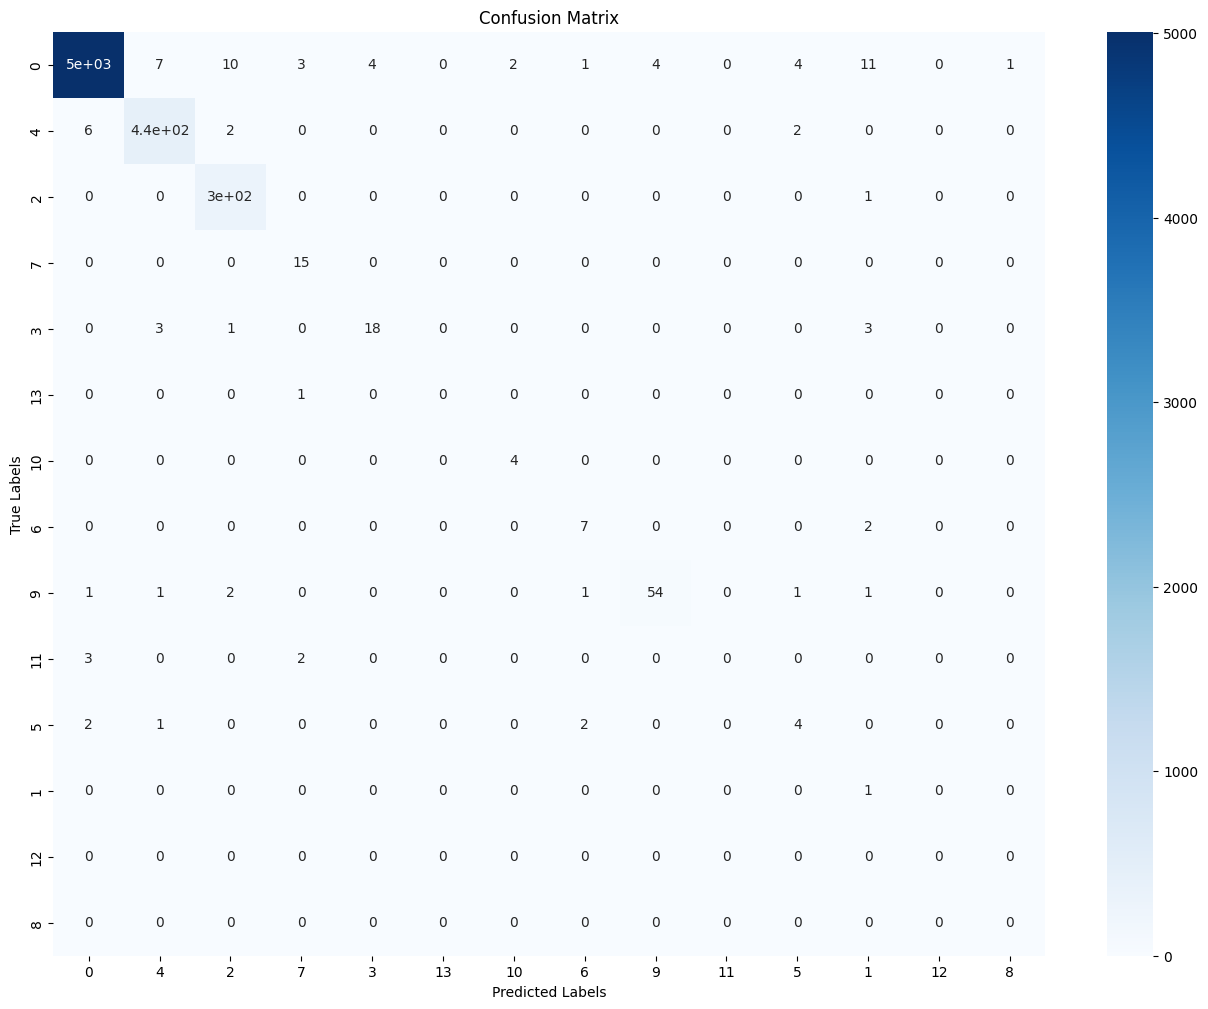

In [76]:
cm = confusion_matrix(y_test_encoded, y_pred, labels=unique_labels)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()

In [77]:
X1_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X1_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
# Check the number of unique labels in your training data
num_classes = len(np.unique(y_train_encoded))
print("Number of unique classes in training data:", num_classes)

# Modify the final layer of your model to match the correct number of classes
model = Sequential()
model.add(LSTM(128, input_shape=(X1_train.shape[1], X1_train.shape[2]), activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='LeakyReLU'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X1_train, y_train_encoded, epochs=10, validation_data=(X1_test, y_test_encoded))

results = model.evaluate(X1_test,y_test_encoded)
print("\n\nAccuracy: %.2f%%" % (results[1]*100))

Number of unique classes in training data: 14
Epoch 1/10
434/434 [==============================] - 10s 10ms/step - loss: 0.5383 - accuracy: 0.9117 - val_loss: 0.1969 - val_accuracy: 0.9403
Epoch 2/10
434/434 [==============================] - 4s 8ms/step - loss: 0.2022 - accuracy: 0.9418 - val_loss: 0.1334 - val_accuracy: 0.9670
Epoch 3/10
434/434 [==============================] - 5s 12ms/step - loss: 0.1647 - accuracy: 0.9508 - val_loss: 0.1221 - val_accuracy: 0.9576
Epoch 4/10
434/434 [==============================] - 4s 8ms/step - loss: 0.1424 - accuracy: 0.9567 - val_loss: 0.0977 - val_accuracy: 0.9724
Epoch 5/10
434/434 [==============================] - 4s 9ms/step - loss: 0.1321 - accuracy: 0.9599 - val_loss: 0.0902 - val_accuracy: 0.9716
Epoch 6/10
434/434 [==============================] - 5s 11ms/step - loss: 0.1255 - accuracy: 0.9624 - val_loss: 0.0881 - val_accuracy: 0.9733
Epoch 7/10
434/434 [==============================] - 4s 9ms/step - loss: 0.1151 - accuracy: 0.963

186/186 [==============================] - 1s 3ms/step


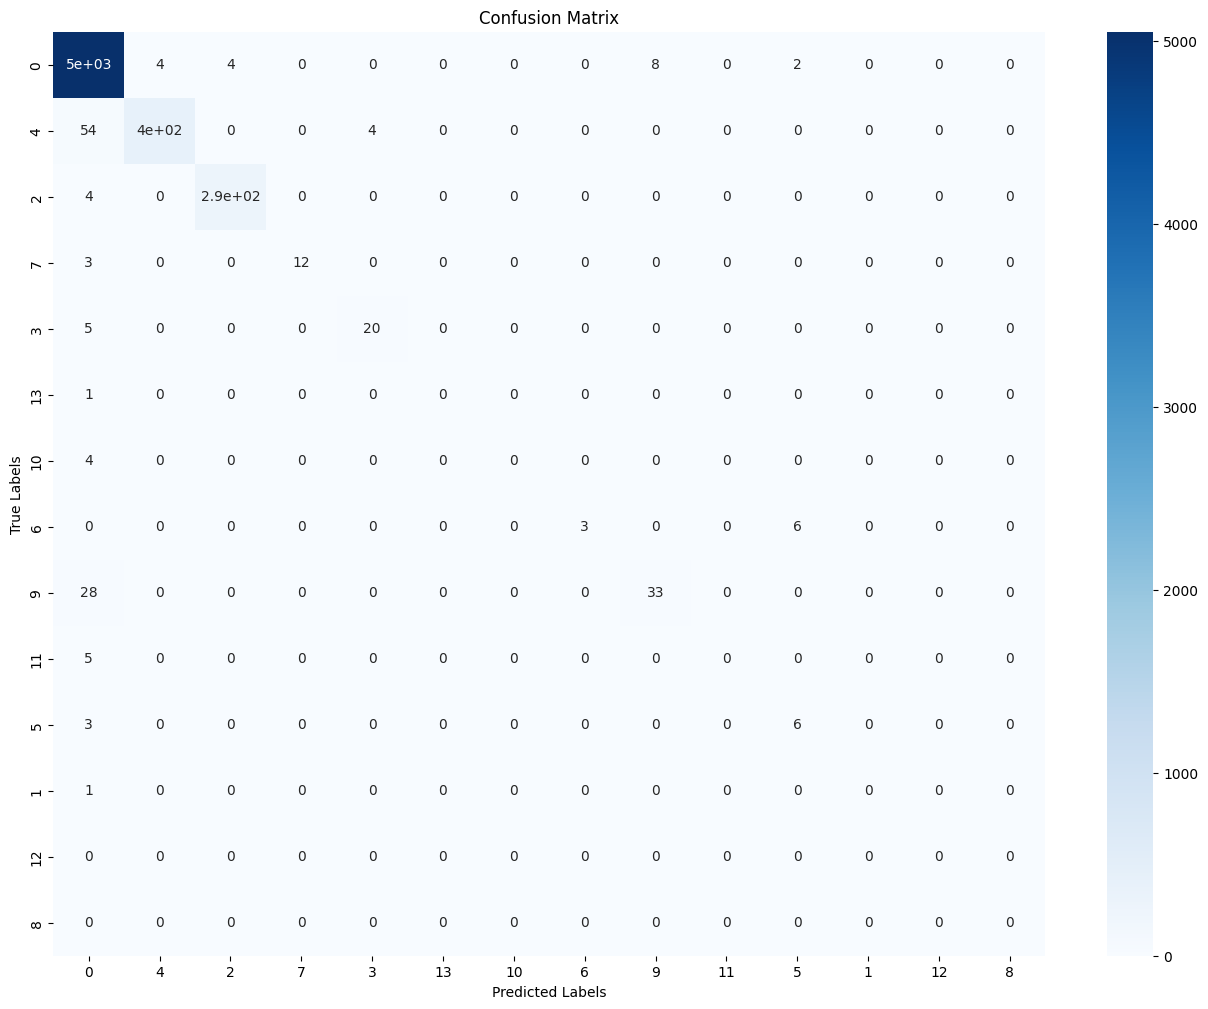

In [78]:
y_pred = np.argmax(model.predict(X1_test), axis=-1)

cm = confusion_matrix(y_test_encoded, y_pred, labels=unique_labels)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()

In [79]:
X2_train = X_train.reshape((X_train.shape[0], 19, 2, 1))
X2_test = X_test.reshape((X_test.shape[0], 19, 2, 1))
# Check the number of unique labels in your training data
num_classes = len(np.unique(y_train_encoded))
print("Number of unique classes in training data:", num_classes)

# MINI-VGGNet model
model = Sequential()
model.add(Conv2D(32, (2, 1), activation='relu', input_shape=(19, 2, 1)))
model.add(Conv2D(32, (2, 1), activation='relu'))
model.add(MaxPooling2D((2, 1)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X2_train, y_train_encoded, epochs=10, validation_data=(X2_test, y_test_encoded))

results = model.evaluate(X2_test,y_test_encoded)
print("\n\nAccuracy: %.2f%%" % (results[1]*100))

Number of unique classes in training data: 14
Epoch 1/10
434/434 [==============================] - 5s 10ms/step - loss: 0.4045 - accuracy: 0.9137 - val_loss: 0.2127 - val_accuracy: 0.9344
Epoch 2/10
434/434 [==============================] - 3s 7ms/step - loss: 0.2203 - accuracy: 0.9338 - val_loss: 0.1666 - val_accuracy: 0.9445
Epoch 3/10
434/434 [==============================] - 3s 6ms/step - loss: 0.1793 - accuracy: 0.9475 - val_loss: 0.1390 - val_accuracy: 0.9569
Epoch 4/10
434/434 [==============================] - 2s 6ms/step - loss: 0.1554 - accuracy: 0.9532 - val_loss: 0.1319 - val_accuracy: 0.9549
Epoch 5/10
434/434 [==============================] - 3s 6ms/step - loss: 0.1383 - accuracy: 0.9568 - val_loss: 0.1451 - val_accuracy: 0.9600
Epoch 6/10
434/434 [==============================] - 3s 8ms/step - loss: 0.1279 - accuracy: 0.9613 - val_loss: 0.1022 - val_accuracy: 0.9716
Epoch 7/10
434/434 [==============================] - 2s 6ms/step - loss: 0.1198 - accuracy: 0.9632 -

186/186 [==============================] - 1s 3ms/step


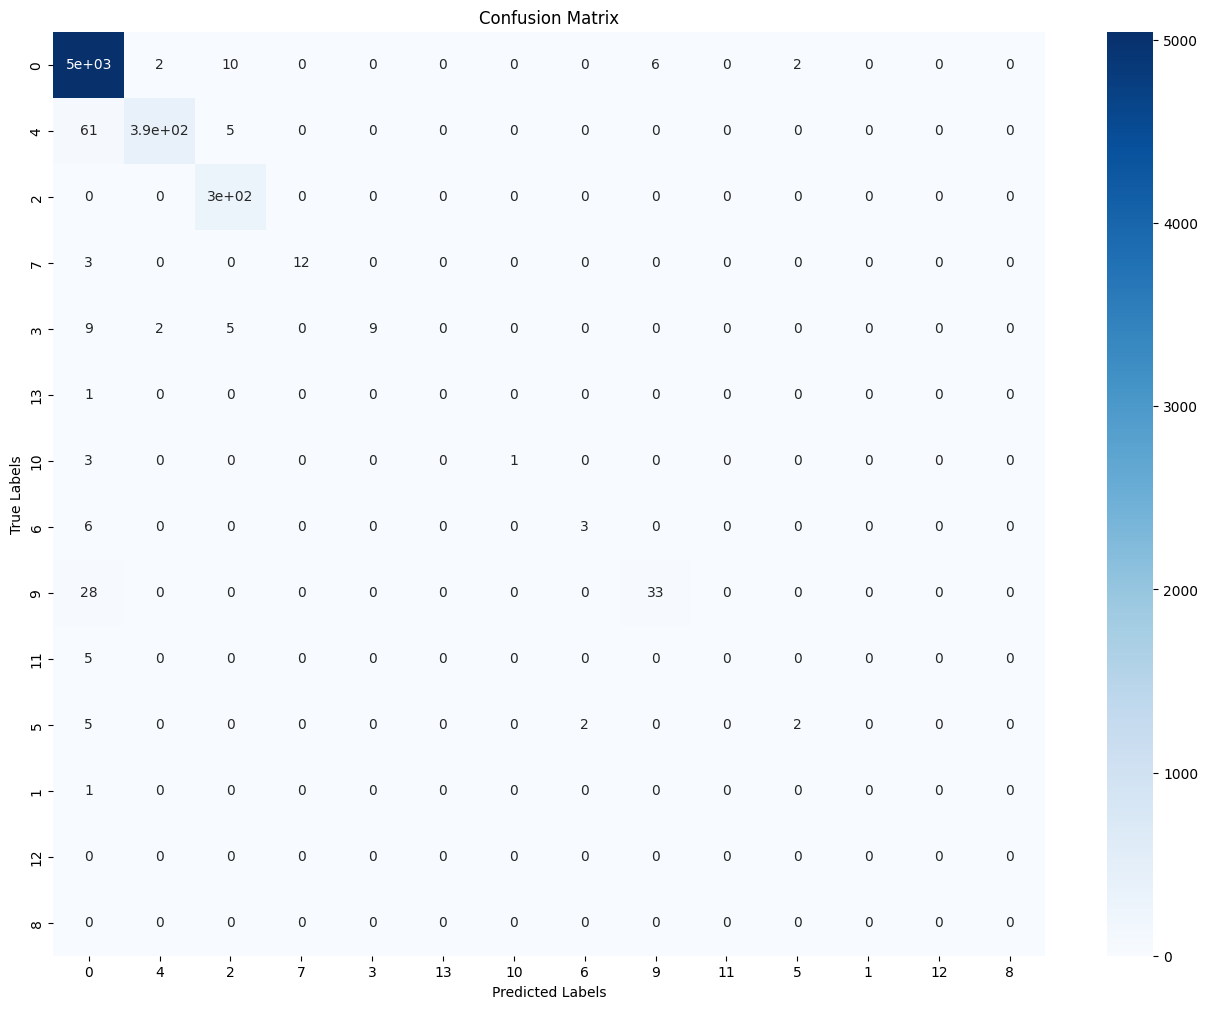

In [80]:
y_pred = np.argmax(model.predict(X2_test), axis=-1)

cm = confusion_matrix(y_test_encoded, y_pred, labels=unique_labels)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()

In [81]:
# Define the AlexNet model
model = Sequential()
model.add(Conv2D(filters=96, kernel_size=(2,1), strides=(4,4), activation='relu', input_shape=(19, 2, 1)))
model.add(MaxPooling2D(pool_size=(2,1), strides=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2,1), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,1), strides=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=384, kernel_size=(2,1), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=384, kernel_size=(2,1), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2,1), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(1,1), strides=(1,1)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
# Determine the number of unique classes
num_classes = len(np.unique(y_train_encoded))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X2_train, y_train_encoded, epochs=2, validation_data=(X2_test, y_test_encoded))

results = model.evaluate(X2_test,y_test_encoded)
print("\n\nAccuracy: %.2f%%" % (results[1]*100))

Epoch 1/2
434/434 [==============================] - 203s 461ms/step - loss: 0.8707 - accuracy: 0.8073 - val_loss: 0.7062 - val_accuracy: 0.8651
Epoch 2/2
186/186 [==============================] - 9s 50ms/step - loss: 0.3396 - accuracy: 0.9124


Accuracy: 91.24%


186/186 [==============================] - 8s 40ms/step


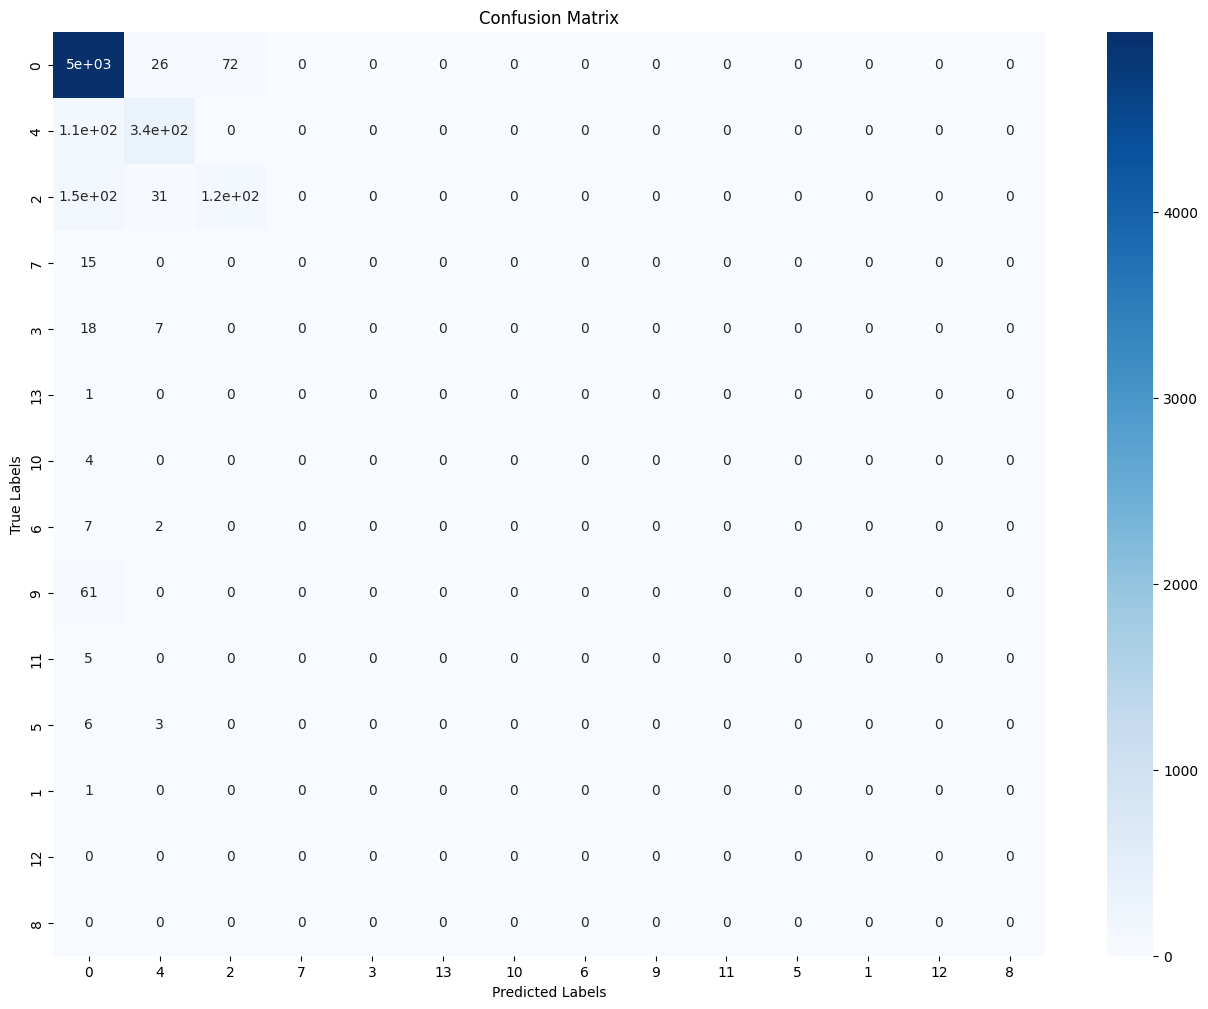

In [82]:
y_pred = np.argmax(model.predict(X2_test), axis=-1)

cm = confusion_matrix(y_test_encoded, y_pred, labels=unique_labels)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()